In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from IPython.display import clear_output
from sklearn import metrics
from scipy.stats import variation

df = pd.read_pickle('treino.pkl.gz')

In [2]:
def tratar_score1(dataframe, series_name, target, seed):
    plt.style.use('default')
    dataframe.loc[dataframe.index.isin(dataframe.loc[dataframe[series_name] < 20].index), series_name] = 0
    x = dataframe.loc[dataframe[series_name] != 0][[series_name]]
    y = dataframe.loc[dataframe[series_name] != 0][[target]]
    mdl = DecisionTreeClassifier(random_state = seed, max_depth = 2)
    mdl.fit(x, y)
    clear_output()
    fig = plt.figure(figsize = (12, 5))
    _ = tree.plot_tree(mdl)
    plt.show()

def tratar_score2(dataframe, series_name, target, t1, t2, t3): 
    z_series = dataframe.loc[dataframe[series_name] == 0][series_name]
    nonz_series = dataframe.loc[dataframe[series_name] != 0][series_name].apply(lambda x: 
                                                                score_new_disc(x, t1, t2, t3))

    disctzd_score = pd.concat([z_series, nonz_series])
    disctzd_score = disctzd_score.rename('new_score')
    dataframe = dataframe.join(disctzd_score).drop(columns = [series_name])
    return dataframe

def score_new_disc(x, t1, t2, t3):
    if x <= t1:
        return 1
    elif x > t1 and x <= t2:
        return 2
    elif x > t2 and x <= t3:
        return 3
    elif x > t3:
        return 4

def discretize(treino, teste, series_name, target, seed):
    
    mdl = DecisionTreeClassifier(max_depth = 2, random_state = seed)
    
    mdl.fit(treino[[series_name]], treino[target])
    teste[series_name + '_proba'] = mdl.predict_proba(teste[[series_name]])[:, 1] 
    
    
    thresh = teste[series_name + '_proba'].unique().tolist()
    thresh.sort()

    teste[series_name + '_proba'] = teste[series_name + '_proba'].apply(lambda x: 
                                                                discretize_proba(x, thresh)) 
    
    teste.drop(columns = [series_name], inplace = True)

def discretize_proba(x, thresh):
    for n in range(len(thresh)):
        if x == thresh[n]:
            return n + 1
        
def proba_box(dataframe, series_name, target, max_depth, random_state):
    
    disc = DecisionTreeClassifier(max_depth = max_depth, random_state = random_state)
    disc.fit(dataframe[[series_name]], dataframe[[target]])
    dataframe[series_name + '_proba'] = disc.predict_proba(dataframe[[series_name]])[:, 1] 
    
    thresh = dataframe[series_name + '_proba'].unique().tolist()
    thresh.sort()

    dataframe[series_name + '_proba'] = dataframe[series_name + '_proba'].apply(lambda x: 
                                                                discretize_proba(x, thresh)) 
    
    thresh = [round(i, 5) for i in thresh]
    print(thresh)
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (11, 5)
    sns.boxplot(dataframe[series_name + '_proba'], dataframe[series_name], showfliers = False)
    plt.show()
    
def tree_thresholds(dataframe, series_name, target, max_depth, random_state):
    mdl = DecisionTreeClassifier(random_state = random_state, max_depth = max_depth)
    mdl.fit(dataframe[[series_name]], dataframe[[target]])
    plt.style.use('default')
    fig = plt.figure(figsize = (12, 5))
    _ = tree.plot_tree(mdl)
    plt.show()

def tree_box_plot(dataframe, series_name, target, iterations, random_state, show_tree = True):
    if show_tree == True:
        for i in iterations:
            tree_thresholds(dataframe, series_name, target, i, random_state)
            proba_box(dataframe, series_name, target, i, random_state)
    
    else:
        for i in iterations:
            tree_thresholds(dataframe, series_name, target, i, random_state)
            clear_output()
            proba_box(dataframe, series_name, target, i, random_state)
       

def target_prop_bin(dataframe, series_name, target):
    plot_data = []
    for i in dataframe[series_name].unique():
        data = dataframe.loc[dataframe[series_name] == i, target].value_counts(1)
        if len(data) == 2:
            plot_data.append([str(i), data.iloc[1]])
        if len(data) < 2:
            plot_data.append([str(i), data.iloc[0]])
            

    plot_data.sort()
    for i in plot_data:
        plt.bar(i[0], i[1], color = 'turquoise')
        
    plt.xticks(range(len(plot_data)), [i[0] for i in plot_data])
    plt.xticks(rotation = 45)
    plt.yticks([])
    plt.show() 

def quali_var_indep_hyp_test(dataframe, series_name, target, alpha):
    
    stat, pval, dof, exp = chi2_contingency(pd.crosstab(dataframe[series_name], dataframe[target]))
    crit = chi2.ppf(q = (1 - alpha), df = dof)
    
    if stat >= crit:
        cramer = np.sqrt( ( stat ) / sum(sum(exp)) * (min(exp.shape) - 1) )
    else:
        cramer = None
    
    return stat, crit, cramer

def pre_proc_and_split(dataframe, target):
    
    aux = dataframe.copy()
    cols = aux.columns.tolist()
    cols.remove(target)
    
    x = aux[cols]
    y = aux[target]
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)
                                        
    for i in cols:
        nr = Normalizer()
        X_train[i] = nr.fit_transform(X_train[[i]])
        X_test[i] = nr.transform(X_test[[i]])
        
    return X_train, X_test, y_train, y_test

def step(xtrain, xtest, ytrain, ytest):
    lr = LogisticRegression()
    lr.fit(xtrain, ytrain)
    pred = lr.predict_proba(xtest)
    
    pr = [i[1] for i in pred]

    score = roc_auc_score(y_true = ytest, y_score = pr) 

    cfs = lr.coef_.tolist()[0]
    cfs = [abs(i) for i in cfs]
    lista = [i for i in zip(cfs, xtest.columns)]
    lista.sort()
    data_cfs = [i[0] for i in lista]
    data_feats = [i[1] for i in lista]

    dropd = lista[0][1]
    lista = lista[1:]
    remaining_feats = [i[1] for i in lista]
    
    return remaining_feats, score, dropd

def my_stepwise(dataframe, target):
    itr = len(dataframe.drop(columns = [target]).columns.tolist()) 
    dici = {}

    for n in range(itr):
    
        xtrain, xtest, ytrain, ytest = pre_proc_and_split(dataframe, target)
        clear_output()
        remaining, score, dropd = step(xtrain, xtest, ytrain, ytest)
        dici[n] = [score, dataframe.columns.tolist()]
        dataframe = dataframe.drop(columns = [dropd])
        
    return dici

def plot_stepwise(dataframe, target):
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = (10, 5)
    d = my_stepwise(dataframe, target)

    plot_vals = []
    for i in d.keys():
        plot_vals.append(d[i][0])
    
    plt.plot(plot_vals)
    plt.show()

    print('FEATURES INCLUÍDAS EM CADA STEP')
    for i in d.keys():
        fs = d[i][1].remove('default')
        print(i , ':', d[i][1])
    print('')
    print('SCORE DE CADA STEP')
    for i in d.keys():
        print(i , ':', round(d[i][0], 5))

def year_to_age(x):

    if x == '00':
        return 20
    
    else:
        return (100 - int(x)) + 20

def time_unit_unification(x):
    
    sub1 = x.split(' ')[0]
    sub2 = x.split(' ')[1]
    return (int(sub1.strip('yrs')) * 12) + int(sub2.strip('mon'))

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 8)

seed = 123

In [3]:
# seleção preliminar de features:
# o critério desta foi: lógica / explicabilidade, as features eliminadas são consideradas como não relacionadas
# à probabilidade de 'deafult'

#  'valor_emprestimo', 'custo_ativo', 'emprestimo_custo' # a
#  'nascimento' # b
#  'emprego' # c 
#  'score', 'score_desc' # d 
#  'qtd_sol_emp' # e
#  'tem_med_emp', 'tem_pri_emp' # f
#  'pri_emp_san','pri_emp_tom', 'pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt' #g   

In [4]:
# iniciamos a análise discretizando variávies quantitativas, caso ordenem o 
# 'default', mantemos estas na análise, caso contrário, já podemos desconsiderá-las, já as variáveis 
# qualitativas são avaliadas com teste qui-quadrado e cramer v

# posteriormente, avaliamos a importância das features restantes, por meio de um
# stepwise

# nota:
# grande parte da análise consiste em discretizar variáveis contínuas e verificar se a taxa de 'default' entre
# bins sobe ou desce respeitando os mesmos, foram testados 16, 8 e 4 bins, com raras exceções, 4 bins foi
# o único número que 'ordenava o default', pensando na 'limpeza' do notebook, os plots incluem apenas
# a discretização em 4 bins

# a.

In [5]:
# valor_emprestimo -> Valor total emprestado pela financeira
# custo_ativo -> Custo do ativo (veículo)
# emprestimo_custo -> Razão entre valor emprestado e valor do ativo (veículo)

# já 'por definição', conclui-se que 'emprestimo_custo' estará altamente correlacionada a uma combinação entre
# 'valor_emprestimo' e 'custo_ativo', estas que, por sua vez, também possuem correlação entre si, como demonstro
# abaixo

In [6]:
pearsonr(df['custo_ativo'], df['valor_emprestimo'])

(0.756227463624271, 0.0)

[0.18339, 0.2062, 0.23523, 0.26119]


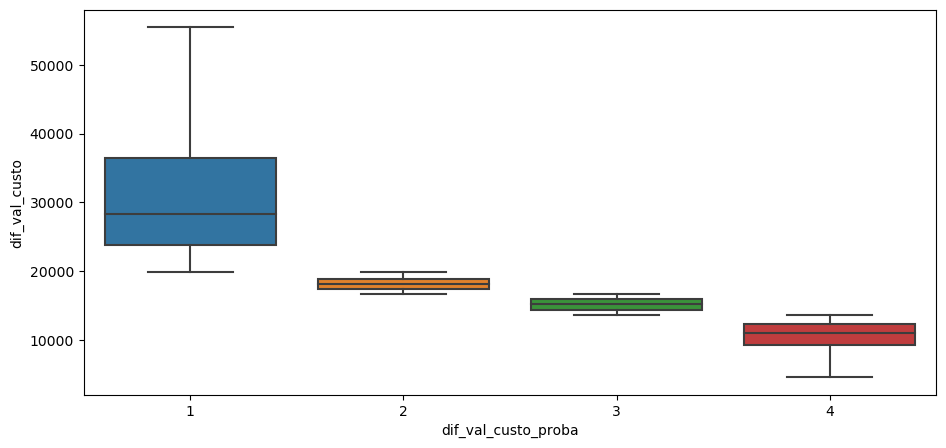

In [7]:
# combinando 'custo_ativo' e 'valor_emprestimo' (independente da correlação, é uma operação intuitiva)
df['dif_val_custo'] = df['custo_ativo'] - df['valor_emprestimo'] 
# discretizando a variável resultante
tree_box_plot(df, 'dif_val_custo', 'default', [2], seed, False)

[0.15071, 0.19158, 0.22556, 0.26505]


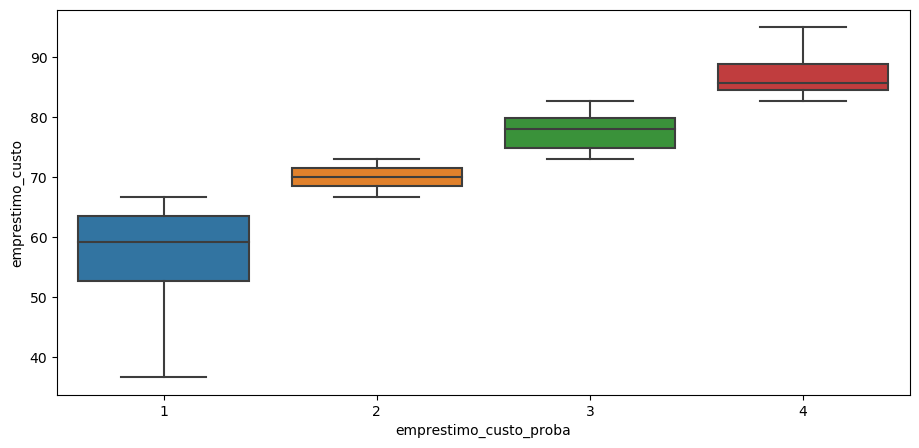

In [8]:
tree_box_plot(df, 'emprestimo_custo', 'default', [2], seed, False)

In [9]:
# conclusão de a.: combinamos 'custo_ativo' e 'valor_emprestimo' em uma única variável, uma vez que possuem
# correlação significativa, em seguida, ao discretizar e plotar os bins, percebemos que a variável discretizada
# ordena o 'default', portanto, esta é válida; prosseguimos com 'emprestimo_custo', ao plotar os bins, 
# fica evidente que esta também ordena o 'default', apesar de possuir correlação com 'dif_custo_val', não
# sei como poderia combiná-las, sendo assim, 'dif_custo_val' e 'emprestimo_custo' permanencem na análise

# b.

In [10]:
# nascimento -> Data de nascimento

# partindo do pressuposto de que a idade do indivíduo possa torná-lo mais suscetível a inadimplência, 
# transformamos a coluna 'nascimento' em 'idade'

[0.19678, 0.2112, 0.22928, 0.24853]


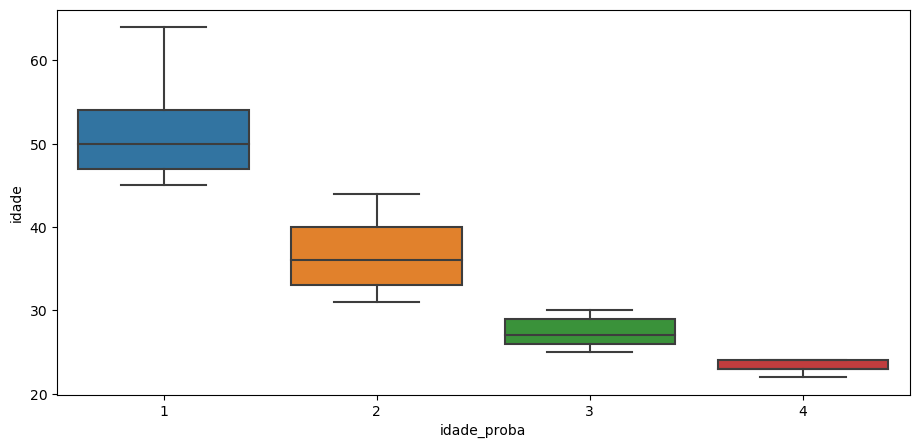

In [11]:
df['nascimento'] = df['nascimento'].str[6:].apply(lambda x: year_to_age(x))
df = df.rename(columns = {'nascimento': 'idade'})
tree_box_plot(df, 'idade', 'default', [2], seed, False)

In [12]:
# conclusão de b.: por mais que possa gerar controvérsias, a variável 'idade' ordena o 'default', logo,
# mantemos esta no modelo

# c.

In [13]:
# emprego -> Tipo de emprego

# considerando que possa haver uma influência do tipo de emprego na renda do indivíduo, esta que por sua vez, 
# estaria relacionada à habilidade do mesmo de quitar suas dívidas, prosseguimos com a análise de 'emprego'

In [14]:
# imputando valores 'nan'
imp = SimpleImputer(strategy = 'constant', fill_value = 'Unknown')
df['emprego'] = imp.fit_transform(df[['emprego']])
df['emprego'] = df['emprego'].str.replace(' ', '_')

stat, crit, cramer = quali_var_indep_hyp_test(df, 'emprego', 'default', 0.05)

print(f'estatística qui-quadrada: {round(stat, 2)}')
print(f'valor_crítico: {round(crit, 2)}')
print(f"Cramér's V: {round(cramer, 3)}")

estatística qui-quadrada: 145.54
valor_crítico: 5.99
Cramér's V: 0.028


In [15]:
# conclusão de c.: Com uma estatística qui-quadrada de 145.54, e um valor crítico de 5.99, falhamos em rejeitar 
# a hipótese nula de independência, todavia, para quantificarmos a associação entre 'emprego' e 'default', 
# consultamos Cramér's V, que acusa associação insignificante

# d.

In [16]:
# score -> Score do Bureau
# score_desc -> Descrição do Score

# seria seguro supor a redundância destas variáveis, entretanto, segue a
# análise destas, a fim de garantir que não perderemos informação, ao eliminar uma delas

df['score_desc'].value_counts(1)

No Bureau History Available                                0.502340
C-Very Low Risk                                            0.068828
A-Very Low Risk                                            0.060464
D-Very Low Risk                                            0.048750
B-Very Low Risk                                            0.039309
M-Very High Risk                                           0.037872
F-Low Risk                                                 0.036709
K-High Risk                                                0.035202
H-Medium Risk                                              0.029214
E-Low Risk                                                 0.024812
I-Medium Risk                                              0.023338
G-Low Risk                                                 0.017161
J-High Risk                                                0.016111
Not Scored: Sufficient History Not Available               0.016084
Not Scored: Not Enough Info available on the cus

In [17]:
# em um primeiro momento, de forma grosseira, considero a possibilidade de dividir os possíveis valores de 
# 'score_desc' entre possuindo a palavra 'Risk' ou se iniciar com 'No'

print(df.loc[df['score_desc'].str.contains('No'), 'score_desc'].unique().tolist())
print('')
print(df.loc[(df['score_desc'].str.contains('Risk')) | 
                    (df['score_desc'].str.contains('Risk')), 'score_desc'].unique().tolist())

['No Bureau History Available', 'Not Scored: Only a Guarantor', 'Not Scored: No Updates available in last 36 months', 'Not Scored: No Activity seen on the customer (Inactive)', 'Not Scored: Sufficient History Not Available', 'Not Scored: Not Enough Info available on the customer', 'Not Scored: More than 50 active Accounts found']

['F-Low Risk', 'A-Very Low Risk', 'C-Very Low Risk', 'H-Medium Risk', 'M-Very High Risk', 'K-High Risk', 'B-Very Low Risk', 'I-Medium Risk', 'D-Very Low Risk', 'E-Low Risk', 'J-High Risk', 'G-Low Risk', 'L-Very High Risk']


In [18]:
# aprofundando análise dos valores de 'score_desc' que possuem 'Risk' ou 'risk'

print(df.loc[df['score_desc'].str.contains('Very Low'), 'score_desc'].unique())
print(df.loc[(df['score_desc'].str.contains('Low')) &
     (df['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df.loc[df['score_desc'].str.contains('Medium'), 'score_desc'].unique())
print(df.loc[(df['score_desc'].str.contains('High')) &
             (df['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df.loc[df['score_desc'].str.contains('Very High'), 'score_desc'].unique())

['A-Very Low Risk' 'C-Very Low Risk' 'B-Very Low Risk' 'D-Very Low Risk']
['F-Low Risk' 'E-Low Risk' 'G-Low Risk']
['H-Medium Risk' 'I-Medium Risk']
['K-High Risk' 'J-High Risk']
['M-Very High Risk' 'L-Very High Risk']


In [19]:
# o que querem dizer as letras?
# são subgrupos de cada tipo de risco, o risco aumenta conforme se percorre o alfabeto

# como se comporta o 'score', para cada 'score_desc' ?

df_risk_letter = df.copy()
df_risk_letter = df_risk_letter.loc[(df_risk_letter['score_desc'].str.contains('Risk')) |
                                    (df_risk_letter['score_desc'].str.contains('risk'))]
df_risk_letter['risk_letter'] = df_risk_letter['score_desc'].str[0]
df_risk_letter[['risk_letter', 'score']].groupby('risk_letter').mean()

,score
risk_letter,
A,827.646657
B,774.158211
C,741.895311
D,715.966128
E,691.516206
F,666.132175
G,640.968760
H,617.100385
I,586.856651


In [20]:
df_risk_word = df.copy()
df_risk_word = df_risk_word.loc[(df_risk_word['score_desc'].str.contains('Risk')) |
                 (df_risk_word['score_desc'].str.contains('risk'))]
df_risk_word['risk_word'] = df_risk_word['score_desc'].str[2:]
df_risk_word[['risk_word', 'score']].groupby('risk_word').mean().sort_values('score')

,score
risk_word,
Very High Risk,303.005018
High Risk,474.778707
Medium Risk,603.669353
Low Risk,668.648474
Very Low Risk,765.769443


[0.14132, 0.17661, 0.22921, 0.26997]


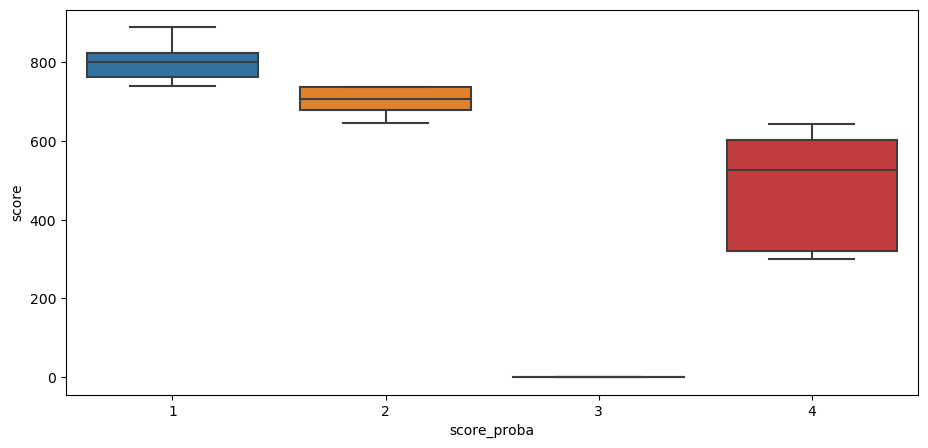

In [21]:
# com estas informações, concluo que não há necessidade de manter ambas variáveis('score' e 'score_desc')
# opto por manter 'score'

# prosseguindo com a análise de 'score'
tree_box_plot(df, 'score', 'default', [2], seed, False)

[0.14132, 0.18185, 0.26329, 0.30377]


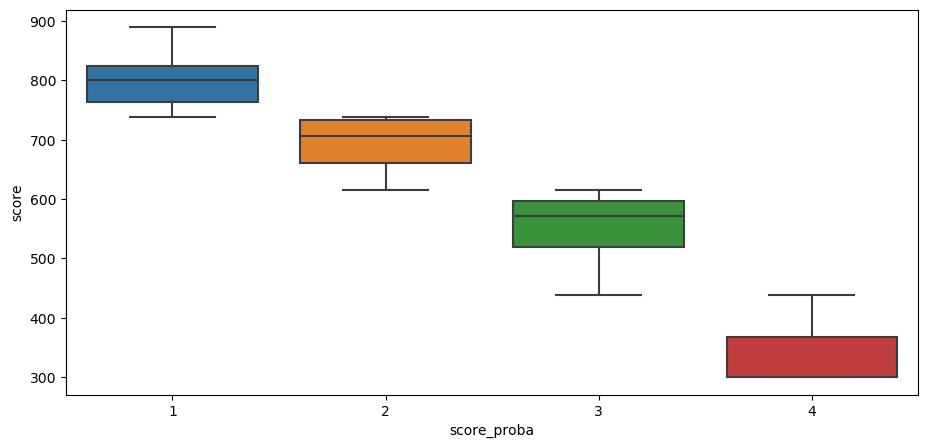

In [22]:
# o grande número de scores iguais a 0 tornam a variável 'score' menos confiável, 
# para contornar este problema, podemos alocar este grupo de dados sob a categoria 0, antes de passar os
# dados no modelo

aux = df.copy()
aux = aux.loc[df['score'] > 20]
tree_box_plot(aux, 'score', 'default', [2], seed, False)

In [23]:
# conclusão de d.: podemos manter apenas 'score', esta precisa ser tratada á parte, alocando certos valores
# sob a categoria '0', e prosseguindo com a discretização nao restante dos dados

# e.

In [24]:
# qtd_sol_emp -> Solicitações de empréstimos feitas pelo cliente

# --- justificar ---

[0.20998, 0.24318, 0.29476]


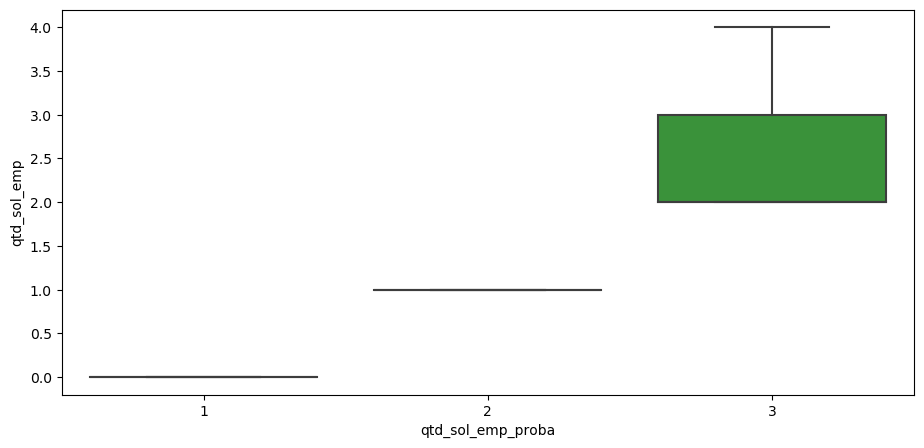

In [25]:
tree_box_plot(df, 'qtd_sol_emp', 'default', [2], seed, False)

In [26]:
# conclusão de e.: a variável se mantém na análise

# f.

In [27]:
# 'tem_med_emp' -> Tempo médio de empréstimo
# 'tem_pri_emp' -> Tempo desde o primeiro empréstimo

# --- justificar --- 

In [28]:
df['tem_med_emp'] = df['tem_med_emp'].apply(lambda x: time_unit_unification(x))
df['tem_pri_emp'] = df['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

[0.05797, 0.19843, 0.22186, 0.23169]


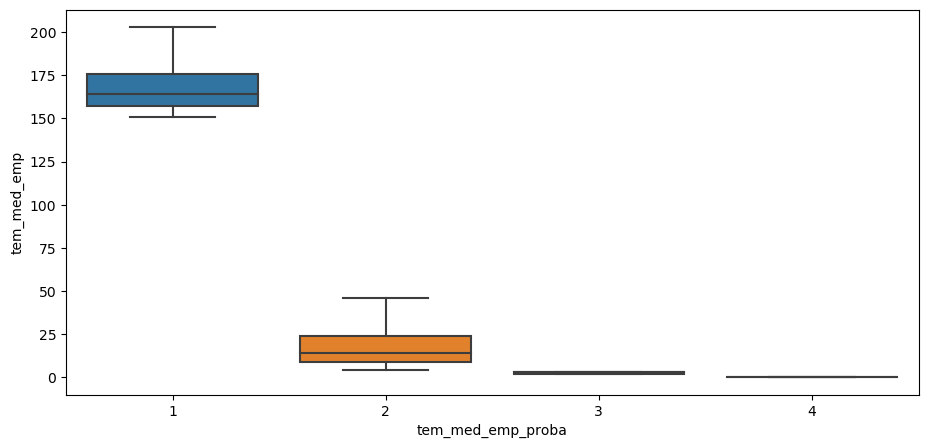

In [29]:
tree_box_plot(df, 'tem_med_emp', 'default', [2], 123, False)

[0.13804, 0.185, 0.2103, 0.23154]


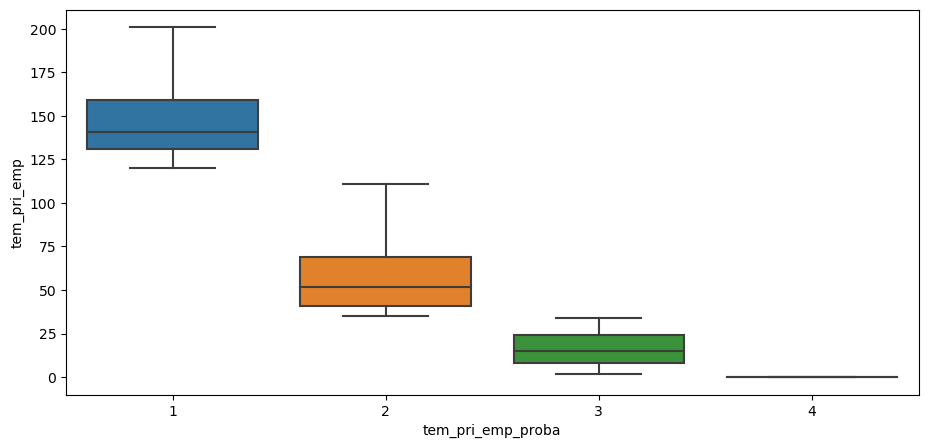

In [30]:
tree_box_plot(df, 'tem_pri_emp', 'default', [2], seed, False)

In [31]:
# conclusão de f.: ambas ordenam o default, também possuem correlação entre si, mas como não sei como 
# combiná-las, mantenho-as no modelo

# g.

In [32]:
# variáveis referentes à conta primária

In [33]:
df[['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 
           'pri_emp_san','pri_emp_tom']].corr()

# percebe-se correlação entre 'pri_qtd_tot_emp' e 'pri_qtd_tot_emp_atv' e 
# 'pri_emp_san' e 'pri_emp_tom' 

# cominarei cada par em uma única variável, assim, além destas duas variáveis resultantes, nos restam:
# pri_qtd_tot_def
# pri_emp_abt

# em g., serão discretizadas quatro variáveis 'finais'

,pri_qtd_tot_emp,pri_qtd_tot_emp_atv,pri_qtd_tot_def,pri_emp_abt,pri_emp_san,pri_emp_tom
pri_qtd_tot_emp,1.000000,0.747670,0.349785,0.294923,0.144879,0.144305
pri_qtd_tot_emp_atv,0.747670,1.000000,0.380439,0.409261,0.202903,0.202099
pri_qtd_tot_def,0.349785,0.380439,1.000000,0.228309,0.109751,0.110922
pri_emp_abt,0.294923,0.409261,0.228309,1.000000,0.432959,0.438819
pri_emp_san,0.144879,0.202903,0.109751,0.432959,1.000000,0.998797
pri_emp_tom,0.144305,0.202099,0.110922,0.438819,0.998797,1.000000


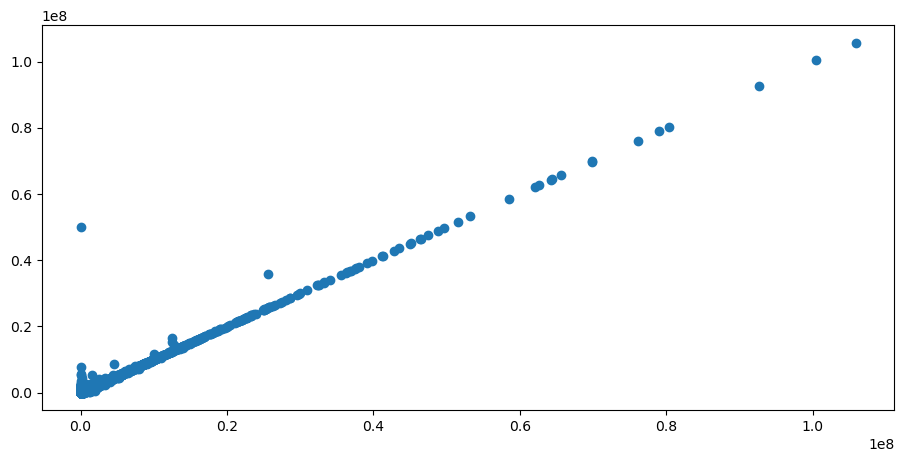

In [34]:
# montante de empréstimo sancionado e montante de empréstimo tomado (correlação muito alta 0.99)
aux = df.copy() 
aux = aux.loc[aux['pri_emp_san'] <= 0.12*10**9] # elimina um outlier
plt.scatter(aux['pri_emp_san'], aux['pri_emp_tom'])
plt.show()

In [35]:
# sobre 'pri_emp_san', 'pri_emp_tom'
# dada a alta correlação, opto por manter apenas 'pri_emp_tom'(são quase a mesma variável)

[0.13173, 0.1716, 0.204, 0.22603]


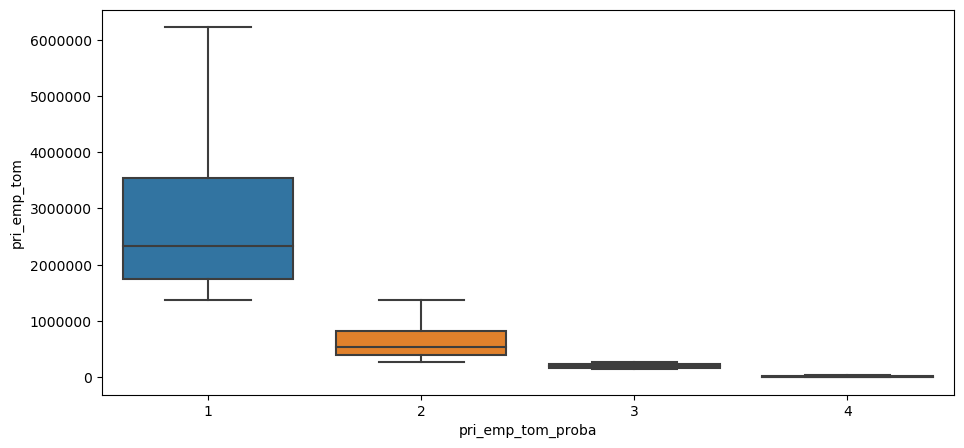

In [36]:
tree_box_plot(df, 'pri_emp_tom', 'default', [2], seed, False)

In [37]:
# combinando 'pri_qtd_tot_emp' e 'pri_qtd_tot_emp_atv'
# transformação 'intuitiva', dado que há correlação (a metadata sobre esta nova variável seria:
# 'empréstimos passados')
df['past_emp'] = df['pri_qtd_tot_emp'] - df['pri_qtd_tot_emp_atv']

[0.18354, 0.20612, 0.22947]


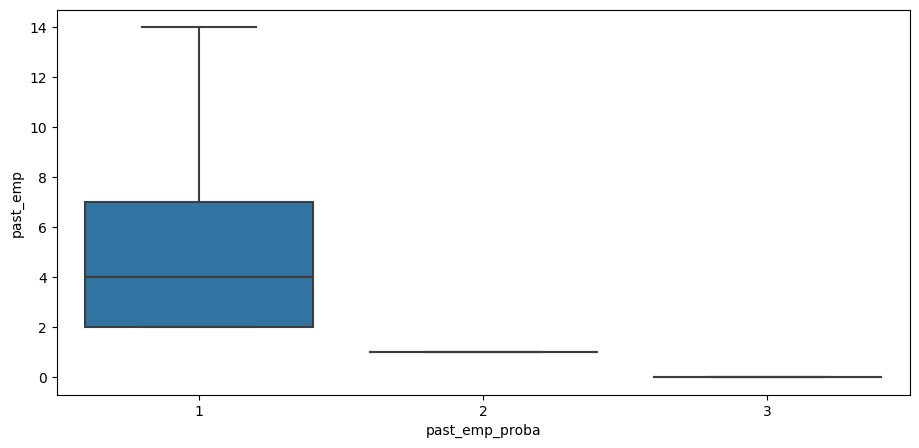

In [38]:
tree_box_plot(df, 'past_emp', 'default', [2], seed, False)

[0.20914, 0.26888, 0.28936]


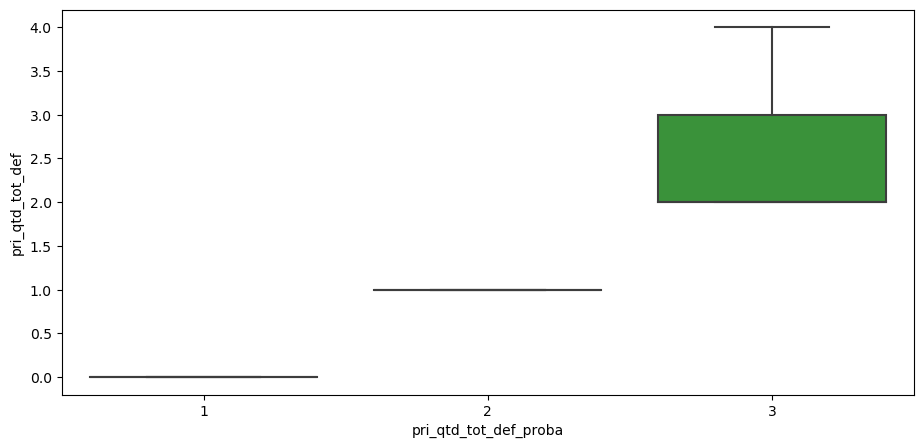

In [39]:
tree_box_plot(df, 'pri_qtd_tot_def', 'default', [2], seed, False)

[0.14165, 0.17822, 0.2227, 0.23373]


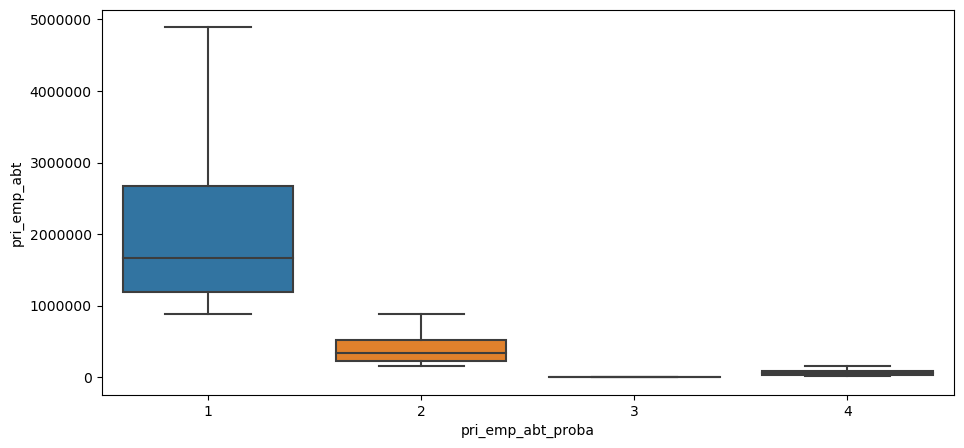

In [40]:
tree_box_plot(df, 'pri_emp_abt', 'default', [2], 123, False)

In [41]:
# conclusão de g.: eliminamos apenas 'pri_emp_abt', mantivemos a nova variável 'past_emp', 'pri_qtd_tot_def' e 
# 'pri_emp_tom', posto que estas ordenam o 'default'

In [42]:
# assim, concluímos a primeira etapa da análise, neste ponto, nos restam as variáveis:

# dif_val_custo_proba (custo_ativo - valor_emprestimo)
# emprestimo_custo_proba
# idade_proba
# score
# tem_med_emp_proba
# tem_pri_emp_proba
# qtd_sol_emp
# pri_emp_tom_proba
# past_emp_proba (pri_qtd_tot_emp - pri_qtd_tot_emp_atv)
# pri_qtd_tot_def_proba

# em seguida, realizamos o stepwise:
# nota: antes é necessário tratar 'score', durante a análise de discretização, pudemos perceber que seria 
# necessário alocar valores de 0-18 sob a categoria '0', com antecedência, mas não tratamos os dados, naquele
# momento

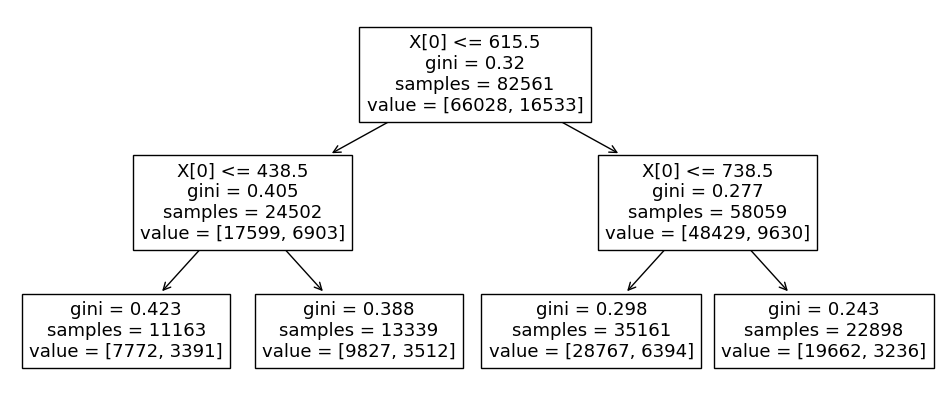

In [43]:
tratar_score1(df, 'score', 'default', seed)

In [44]:
df = tratar_score2(df, 'score', 'default', 438.5, 615.5, 738.5)

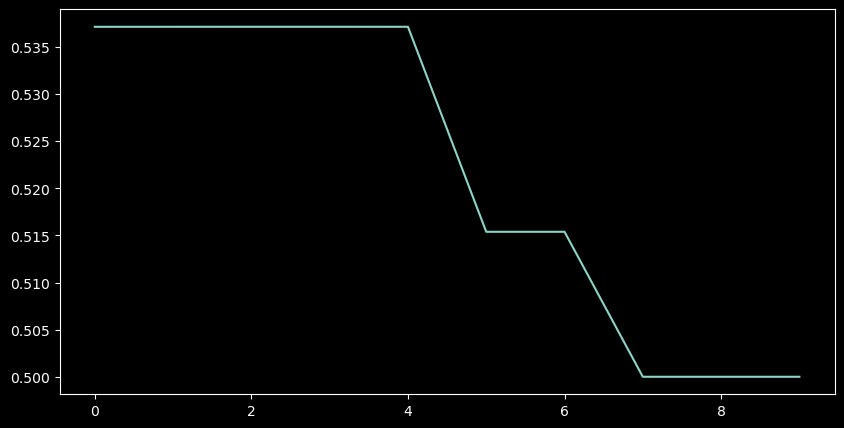

FEATURES INCLUÍDAS EM CADA STEP
0 : ['dif_val_custo_proba', 'emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp', 'pri_emp_tom_proba', 'past_emp_proba', 'pri_qtd_tot_def_proba']
1 : ['dif_val_custo_proba', 'emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp', 'pri_emp_tom_proba', 'pri_qtd_tot_def_proba']
2 : ['dif_val_custo_proba', 'emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp', 'pri_emp_tom_proba']
3 : ['emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp', 'pri_emp_tom_proba']
4 : ['emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp']
5 : ['emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'tem_pri_emp_proba', 'qtd_sol_emp']
6 : ['idade_proba', 'tem_med_emp_proba', 'tem_pri_emp_proba', 'q

In [45]:
df = df.copy()[['dif_val_custo_proba' ,'emprestimo_custo_proba','idade_proba','tem_med_emp_proba','new_score',
'tem_pri_emp_proba','qtd_sol_emp','pri_emp_tom_proba','past_emp_proba' ,'pri_qtd_tot_def_proba','default']]
plot_stepwise(df, 'default')

In [46]:
# assim, concluímos a seleção de variáveis, trabalharemos com:

['emprestimo_custo_proba', 'idade_proba', 'tem_med_emp_proba', 'new_score', 'tem_pri_emp_proba', 'qtd_sol_emp']

['emprestimo_custo_proba',
 'idade_proba',
 'tem_med_emp_proba',
 'new_score',
 'tem_pri_emp_proba',
 'qtd_sol_emp']

In [47]:
# pipeline para tratar e testar dados
df = pd.read_pickle('treino.pkl.gz')
df = df.copy()[['emprestimo_custo', 'nascimento', 
                'tem_med_emp', 'score', 'tem_pri_emp', 'qtd_sol_emp', 'default']]

df['nascimento'] = df['nascimento'].str[6:].apply(lambda x: year_to_age(x))
df = df.rename(columns = {'nascimento': 'idade'})
df['tem_med_emp'] = df['tem_med_emp'].apply(lambda x: time_unit_unification(x))
df['tem_pri_emp'] = df['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

kf = KFold(n_splits = 3, random_state = seed, shuffle = True)
d = {}
n = 0
for train_index, test_index in kf.split(df):
    d[n] = [[train_index.tolist()], [test_index.tolist()]]
    n += 1

treino_0 = df.iloc[d[0][0][0]]
teste_0 = df.iloc[d[0][1][0]]

treino_1 = df.iloc[d[1][0][0]]
teste_1 = df.iloc[d[1][1][0]]

treino_2 = df.iloc[d[2][0][0]]
teste_2 = df.iloc[d[2][1][0]]

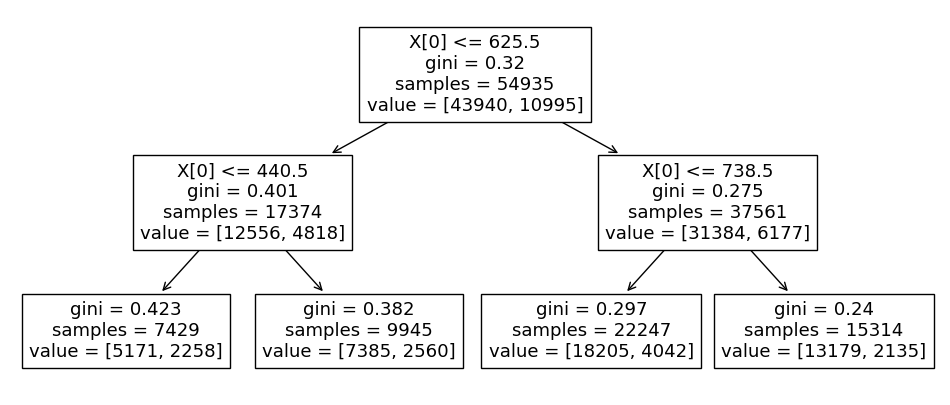

In [48]:
tratar_score1(treino_0, 'score', 'default', seed)

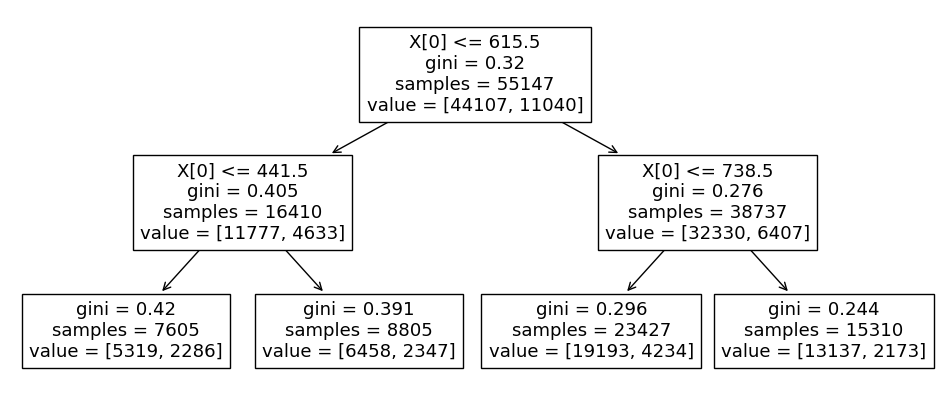

In [49]:
tratar_score1(treino_1, 'score', 'default', seed)

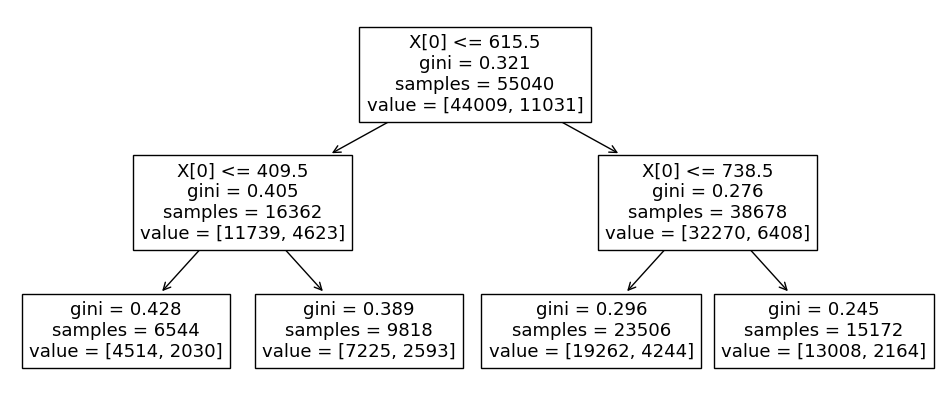

In [50]:
tratar_score1(treino_2, 'score', 'default', seed)

In [51]:
teste_0 = tratar_score2(teste_0, 'score', 'default', 440.5, 625.5, 738.5)
teste_1 = tratar_score2(teste_1, 'score', 'default', 441.5, 615.5, 738.5)
teste_2 = tratar_score2(teste_2, 'score', 'default', 409.5, 615.5, 738.5)
treino_0 = tratar_score2(treino_0, 'score', 'default', 440.5, 625.5, 738.5)
treino_1 = tratar_score2(treino_1, 'score', 'default', 441.5, 615.5, 738.5)
treino_2 = tratar_score2(treino_2, 'score', 'default', 409.5, 615.5, 738.5)


for col in ['emprestimo_custo', 'idade', 'tem_med_emp', 'tem_pri_emp', 'qtd_sol_emp']:
    discretize(treino_0, teste_0, col, 'default', seed)
    discretize(treino_1, teste_1, col, 'default', seed)
    discretize(treino_2, teste_2, col, 'default', seed)
    
for col in ['emprestimo_custo', 'idade', 'tem_med_emp', 'tem_pri_emp', 'qtd_sol_emp']:
    tree_box_plot(treino_0, col, 'default', [2], seed, False)
    treino_0.drop(columns = [col], inplace = True)
    tree_box_plot(treino_1, col, 'default', [2], seed, False)
    treino_1.drop(columns = [col], inplace = True)
    tree_box_plot(treino_2, col, 'default', [2], seed, False)
    treino_2.drop(columns = [col], inplace = True)
    clear_output()

In [52]:
expl = ['new_score', 'tem_med_emp_proba', 'tem_pri_emp_proba', 'qtd_sol_emp_proba', 'emprestimo_custo_proba', 
       'idade_proba']

trgt = ['default']

lr0 = LogisticRegression()
lr0.fit(treino_0[expl], treino_0[trgt])

lr1 = LogisticRegression()
lr1.fit(treino_1[expl], treino_1[trgt])

lr2 = LogisticRegression()
lr2.fit(treino_2[expl], treino_2[trgt])

tr = 2 * roc_auc_score(teste_0[trgt], [i[1] for i in lr0.predict_proba(teste_0[expl])]) - 1
print(tr)
tr = 2 * roc_auc_score(teste_1[trgt], [i[1] for i in lr1.predict_proba(teste_1[expl])]) - 1
print(tr)
tr = 2 * roc_auc_score(teste_2[trgt], [i[1] for i in lr2.predict_proba(teste_2[expl])]) - 1
print(tr)

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.195628315196406
0.2083470909054712
0.19035040356143784
